In [1]:
%%javascript
require(['base/js/utils'],
function(utils) {
   utils.load_extensions('calico-spell-check', 'calico-document-tools', 'calico-cell-tools');
});

<IPython.core.display.Javascript object>

In [1]:
# imports
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import seaborn as sns
from pylab import rcParams

sns.set(style="ticks")
sns.set_style("whitegrid")
rcParams['figure.dpi'] = 350
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'
rcParams['font.size'] = 20
rcParams['figure.figsize'] = (10,10)
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20

## Load the web page
---
In order to increase the readability of this notebook, the web scrapping process is written in the `web_scrapper` class and imported to this notebook. It scraps the summary and standings tables from https://www.transfermarkt.com/premier-league/startseite/wettbewerb/GB1/plus/?saison_id=2017 in the range between 2005 to 2017 and convert merge it to a giant dictionary with the year as the key and the summary detail of premier league in that year as the value.

In [3]:
from web_scrapper import web_scrapper

In [4]:
my_web_scrapper = web_scrapper()
try:
    my_web_scrapper.connect()
except requests.ConnectionError as detail:
    print(detail)

Request Succeeded!


In [5]:
summary_dfs = my_web_scrapper.digest()

In [6]:
summary_dfs[2005].head(3)

Avg. Market Values Avg. Player age     Club Full Name Club Short Name  \
0      13,04 Mill. €            24,5         Chelsea FC         Chelsea   
1       9,89 Mill. €            24,9  Manchester United         Man Utd   
2       6,63 Mill. €            23,3         Arsenal FC         Arsenal   

  Total Market Values  Position Goal Difference Points  
0      352,18 Mill. €         1              50     91  
1      286,93 Mill. €         2              38     83  
2      218,95 Mill. €         4              37     67

## Prepare the data
---
As we see above in the table, the data scrapped from https://www.transfermarkt.com are in good shape. However, we have to clean this data for machine learning's sake since model will only accept numeric inputs.

In [7]:
big_summary_df = pd.DataFrame()
for key, df in summary_dfs.items():
    df["Year"] = key
    big_summary_df = pd.concat((big_summary_df, df))

In [8]:
big_summary_df.reset_index(drop=True, inplace=True)
big_summary_df.tail(3)

Avg. Market Values Avg. Player age   Club Full Name Club Short Name  \
277       2,53 Mill. €            25,6     Norwich City         Norwich   
278       2,61 Mill. €            25,9   Leicester City       Leicester   
279       1,39 Mill. €            24,1  AFC Bournemouth     Bournemouth   

    Total Market Values  Position Goal Difference Points  Year  
277      103,75 Mill. €        19             -28     34  2015  
278       91,25 Mill. €         1              32     81  2015  
279       68,03 Mill. €        16             -22     42  2015

For the sake of readability, we can use a helper class which helps us to move the unit of both "Avg. Market Values" and "Total Market Values" to the column names. Then it can change all the cells that are numeric values to a proper data type.

In [9]:
from df_cleaner import df_cleaner

In [10]:
my_df_cleaner = df_cleaner()
numeric_big_summary_df = my_df_cleaner.cook(big_summary_df)
numeric_big_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 9 columns):
Avg. Market Values(Mill. €)     280 non-null float64
Avg. Player age                 280 non-null float64
Club Full Name                  280 non-null object
Club Short Name                 280 non-null object
Total Market Values(Mill. €)    280 non-null float64
Position                        280 non-null int64
Goal Difference                 280 non-null int64
Points                          280 non-null int64
Year                            280 non-null int64
dtypes: float64(3), int64(4), object(2)
memory usage: 19.8+ KB


In [11]:
numeric_big_summary_df.head(3)

Avg. Market Values(Mill. €)  Avg. Player age     Club Full Name  \
0                        14.12             24.7    Manchester City   
1                        12.31             23.8         Chelsea FC   
2                        12.70             23.5  Manchester United   

  Club Short Name  Total Market Values(Mill. €)  Position  Goal Difference  \
0        Man City                        621.40         3               41   
1         Chelsea                        603.30         1               52   
2         Man Utd                        533.25         6               25   

   Points  Year  
0      78  2016  
1      93  2016  
2      69  2016

## EDA
---
Before we feed the data to the model, it is important that we can analyse the data both visually and numerically first. It will give us more intuition of the problem we are trying to solve.

In [12]:
def color_strong_corr_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for strong correlations
    , black otherwise.
    """
    color = 'red' if (val > 0.6 or val < -0.6)  else 'black'
    return 'color: %s' % color

As the correlation table will be most intuitive, we can take a look which two numeric features have a strong correlation.

In [13]:
numeric_big_summary_df.corr().style.applymap(color_strong_corr_red)

We can see that total market values of a club has a relationship with both position and goal difference. Let's visualise this relationship.

In [14]:
g = sns.PairGrid(numeric_big_summary_df[numeric_big_summary_df["Year"]!=2018].iloc[:, :-1], height=5)
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.kdeplot)

## Training and Testing
---
Before regression, we need a mechanism to help us evaluating our prediction result. Thus, we need to split the dataset into training set and testing set.

Firstly, for convenience, the training set and test set will use abbreviated column names. However, for readability, plotting will still use the full name DataFrame 

In [15]:
training_set_df = numeric_big_summary_df.copy()

old_col_name_list = training_set_df.columns
training_set_df.rename(columns={
    old_col_name_list[0]: "avg_mv",
    old_col_name_list[1]: "avg_age",
    old_col_name_list[2]: "full",
    old_col_name_list[3]: "short",
    old_col_name_list[4]: "total_mv",
    old_col_name_list[5]: "pos",
    old_col_name_list[6]: "gd",
    old_col_name_list[7]: "pts",
    old_col_name_list[8]: "year",
}, inplace=True)

we need to split the 2018 year dataset since this is our objective in this project, to predict the standing of this year.

In [16]:
prediction_input_df = training_set_df[training_set_df["year"] == 2018]
training_set_df.drop(prediction_input_df.index, axis=0, inplace=True)

Secondly, the dataset need to be split to training set and testing set. The radio of training set is 80% and of testing set is 20%.

In [17]:
testing_set_df = training_set_df.sample(frac=0.2)
training_set_df.drop(testing_set_df.index, axis=0, inplace=True)

Take a look what two sets look like

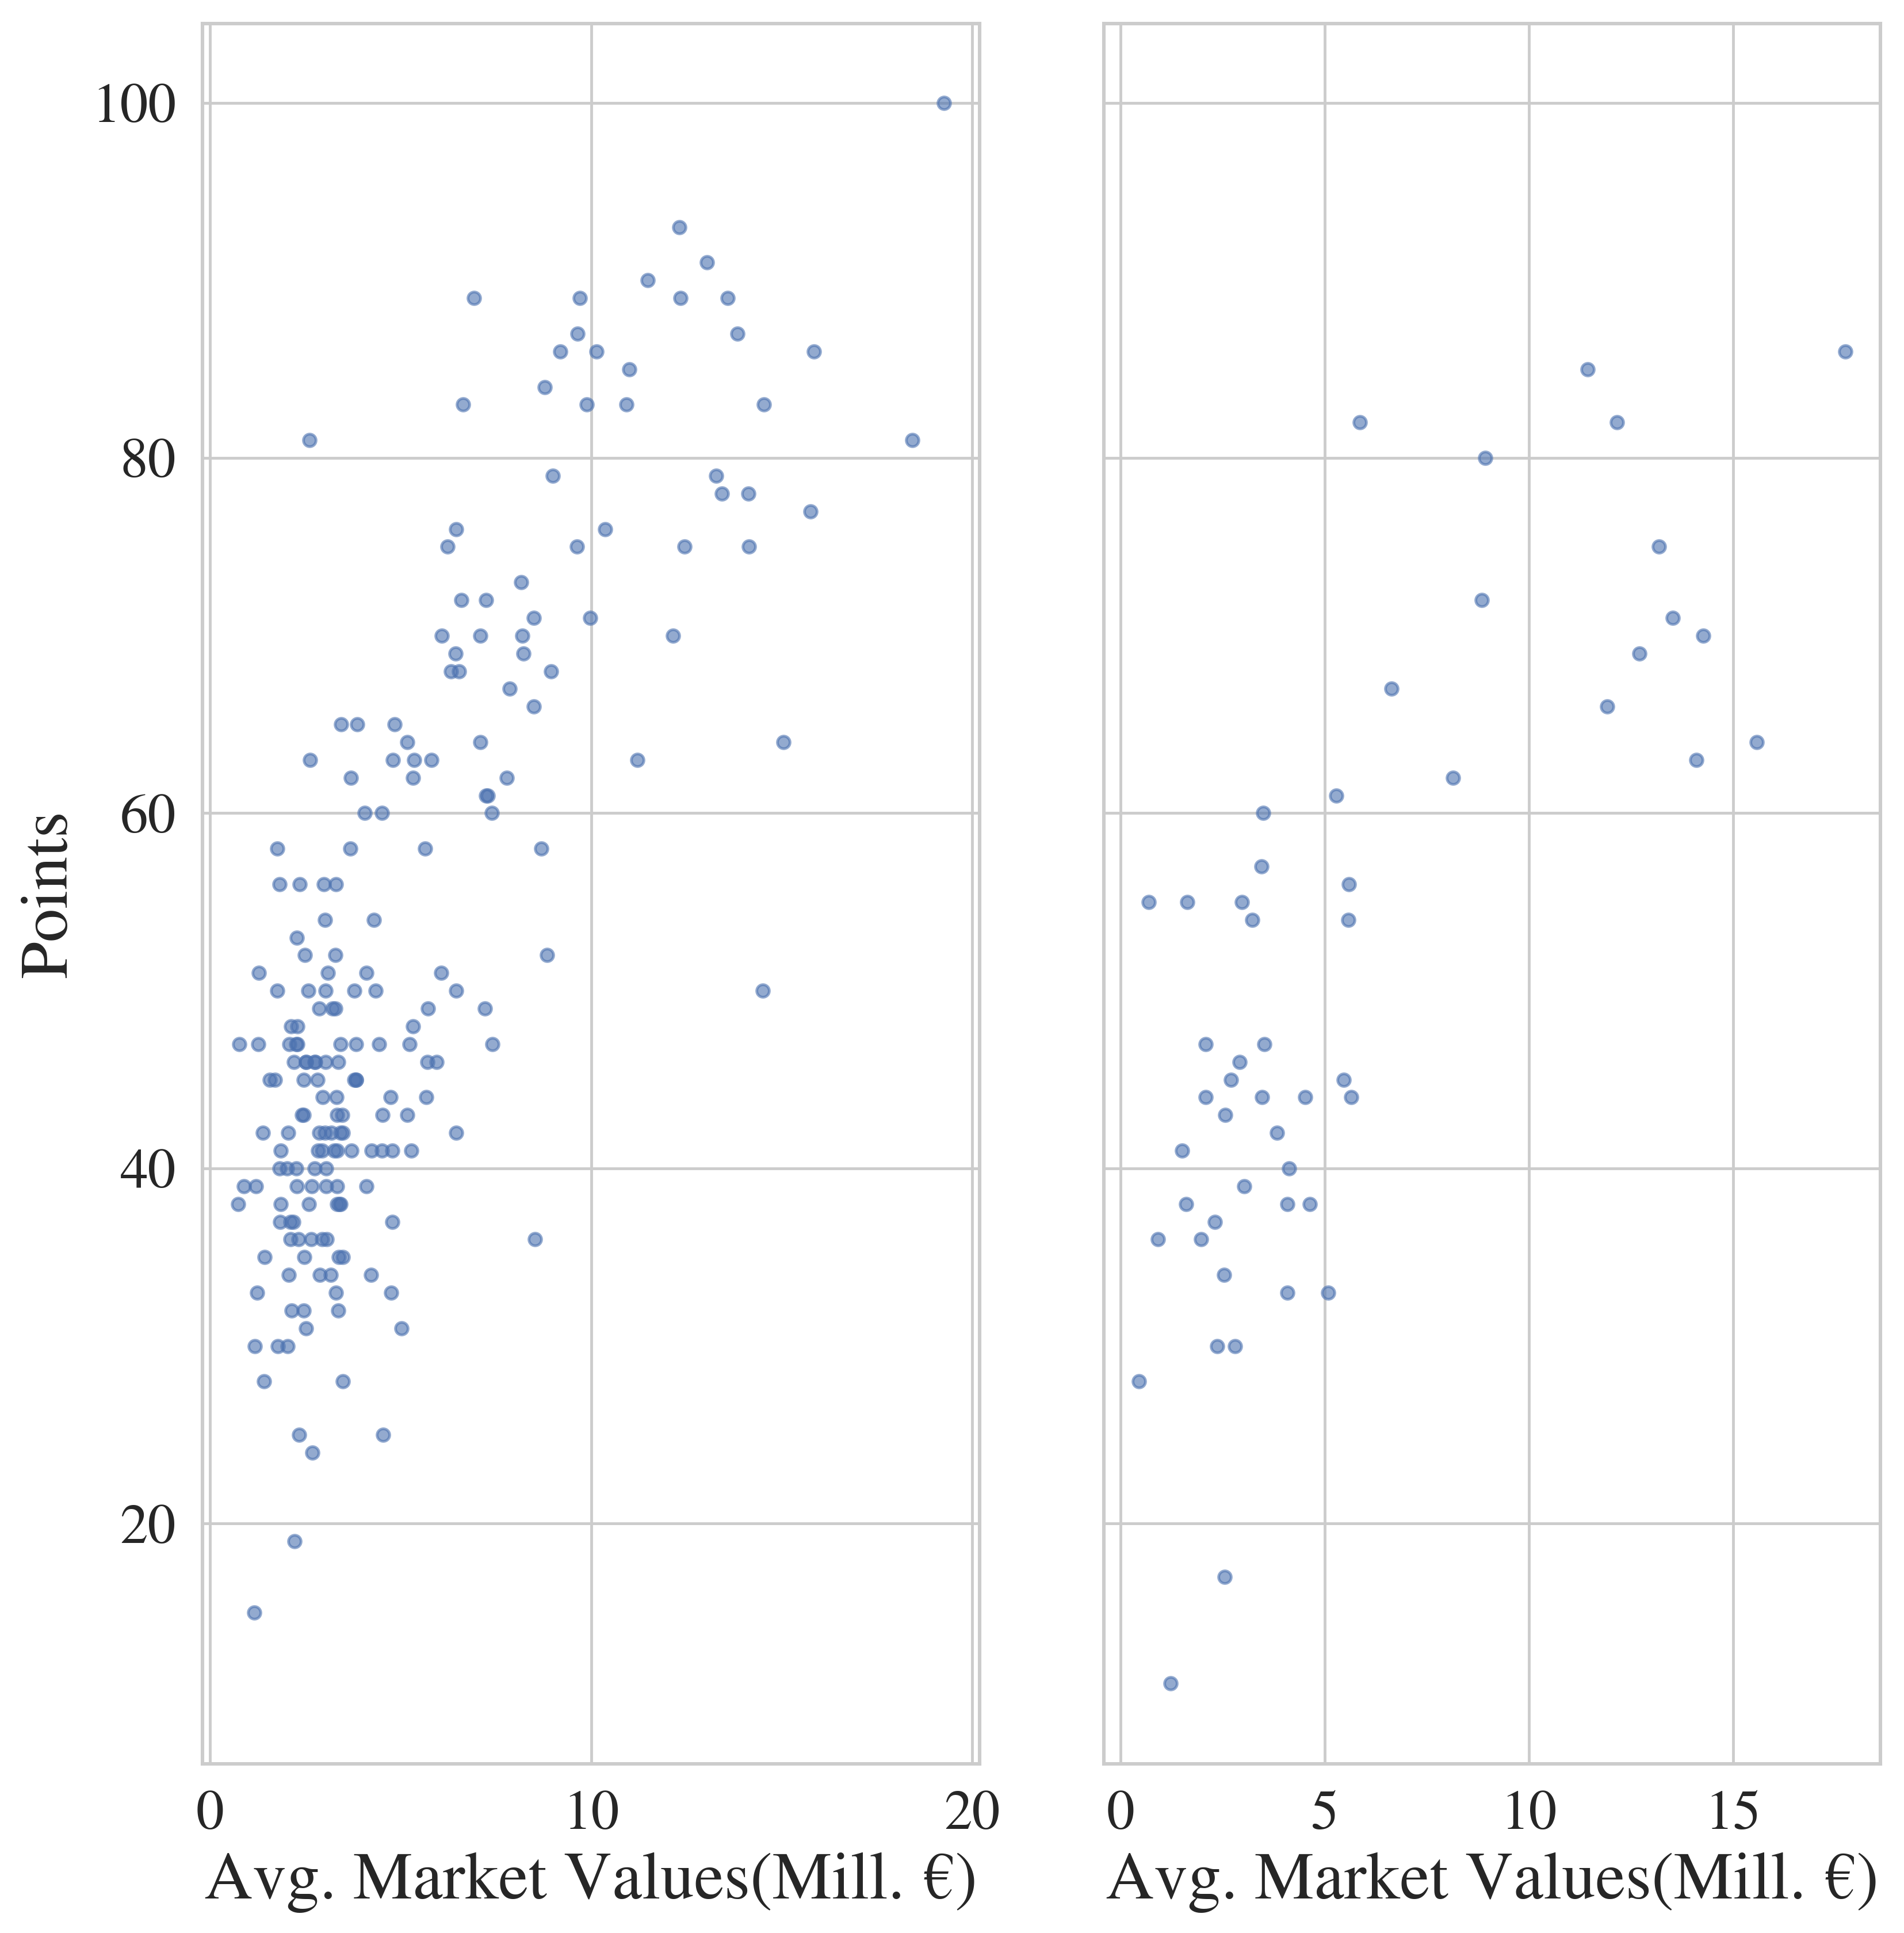

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(training_set_df.avg_mv, training_set_df.pts, s=20, alpha=0.6)
ax1.set_xlabel(numeric_big_summary_df.columns[0])
ax1.set_ylabel("Points")
ax2.scatter(testing_set_df.avg_mv, testing_set_df.pts, s=20, alpha=0.6)
ax2.set_xlabel(numeric_big_summary_df.columns[0])
fig.tight_layout()

## Linear Regression
---
Firstly, let's use a linear hypothesis function to describe the relationship, and evaluate the performance.

In [19]:
from ml_agent import linear_agent

It will be more intuitive for use to evaluate how good is our model to use a one-number evaluation.
To achieve this objective, we can calculate the square mean difference for the test set and prediction, the smaller the loss is, the better the model can predict.

$$
loss = \sum_{i=1}^{n} (y_i - h(x_i))^2
$$

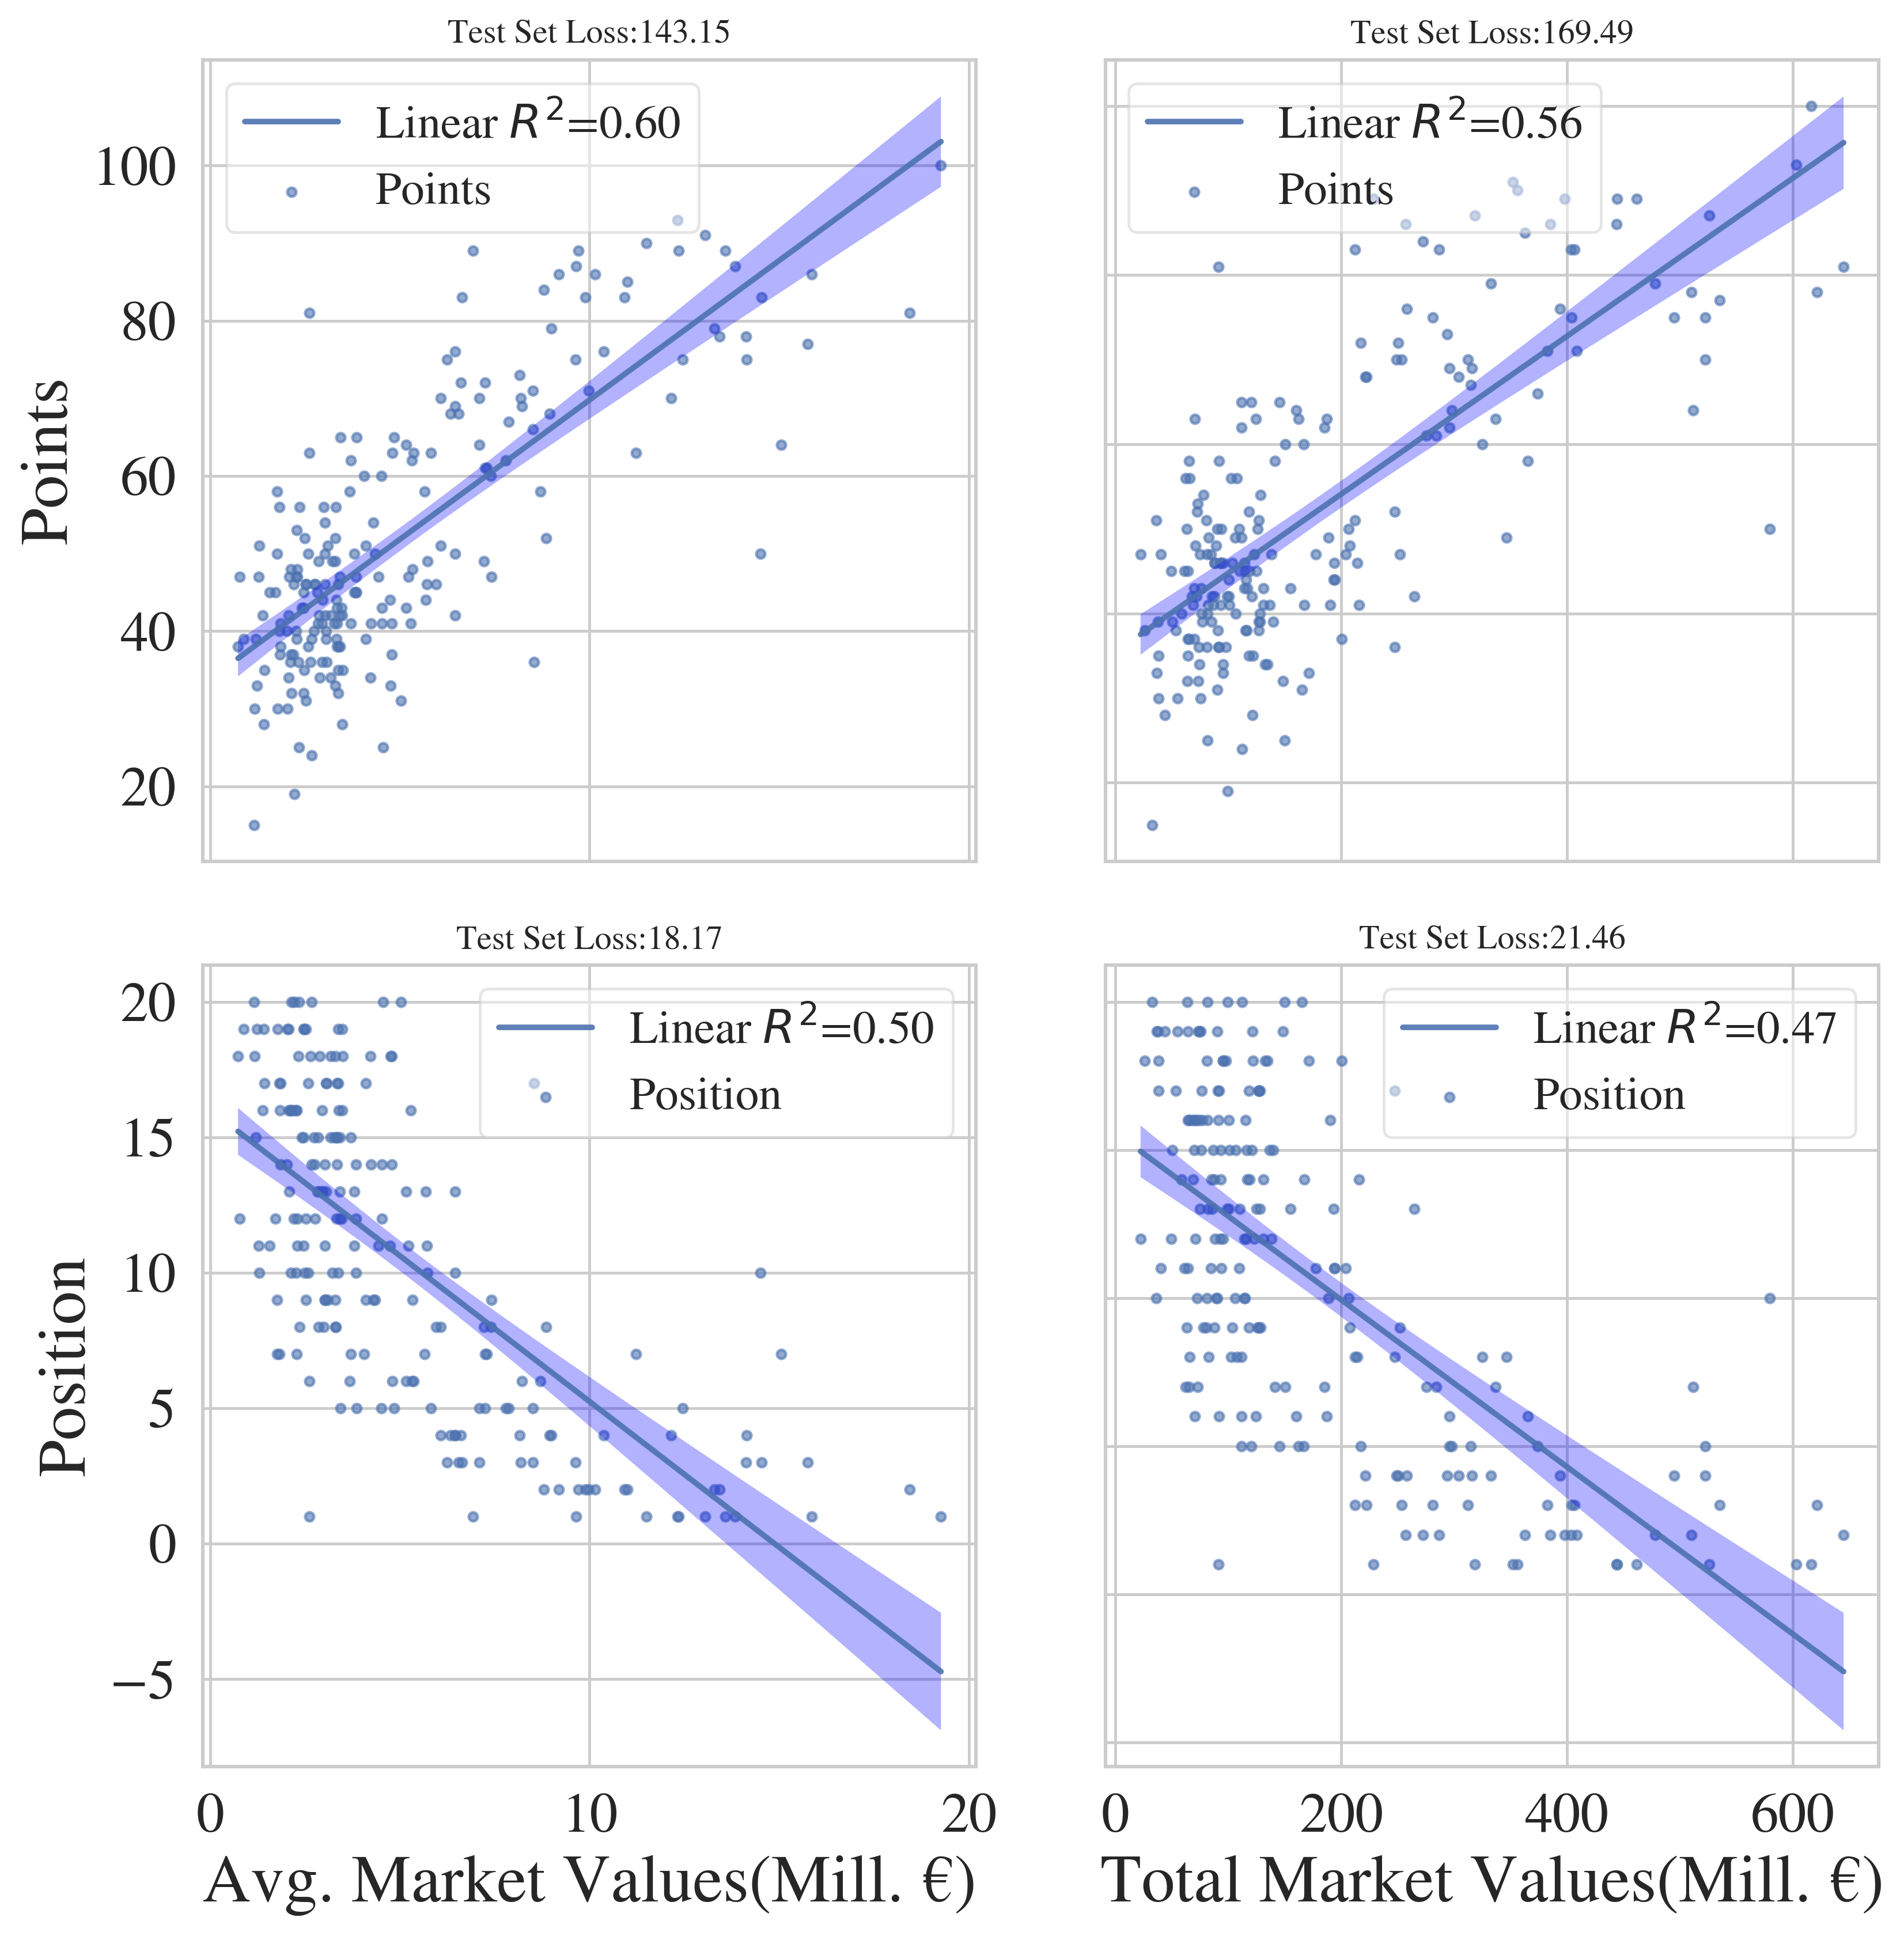

In [20]:
my_linear_agent = linear_agent(confidence=0.95)
my_linear_agent.train(train_data=training_set_df)
my_linear_agent.evaluate(train_data=training_set_df, test_data=testing_set_df, col_names=numeric_big_summary_df.columns)

From above plots we can observe that average market values is more accurate to predict. However, from the plots, intuitively we can see the linear hypothesis function is not confident enough for the training set. Will non-linear hypothesis function have a better performance to solve this problem? 

In [21]:
linear_prediction_df = my_linear_agent.predict(prediction_input_df)
linear_prediction_df.head(4)

Linear Model                               \
                  Avg. Market Values: Points Avg. Market Values: Position   
Manchester City                   175.299134                   -26.336205   
Liverpool FC                      148.232014                   -18.234120   
Chelsea FC                        135.291558                   -14.360614   
Manchester United                 152.042259                   -19.374653   

                                                                             
                  Total Market Values: Points Total Market Values: Position  
Manchester City                    134.379297                    -14.319089  
Liverpool FC                       118.601230                     -9.551576  
Chelsea FC                         117.084108                     -9.093161  
Manchester United                  115.240222                     -8.536011

Obviously, we have a couple of issues with linear model:
1. Data set has a more than linear relationship, the model is under-fitting the data set.
2. The market values are increasing overall, however, the points will not increase accordingly. There is a celling for the points a club can gain for whole season, which a club needs to win 38 games to gain 114 points at most. However, in this model, 2018 season prediction is clearly over-estimated.

## Non-linear Regression
---
### Polynomial n=2

In [22]:
from ml_agent import poly_2_agent

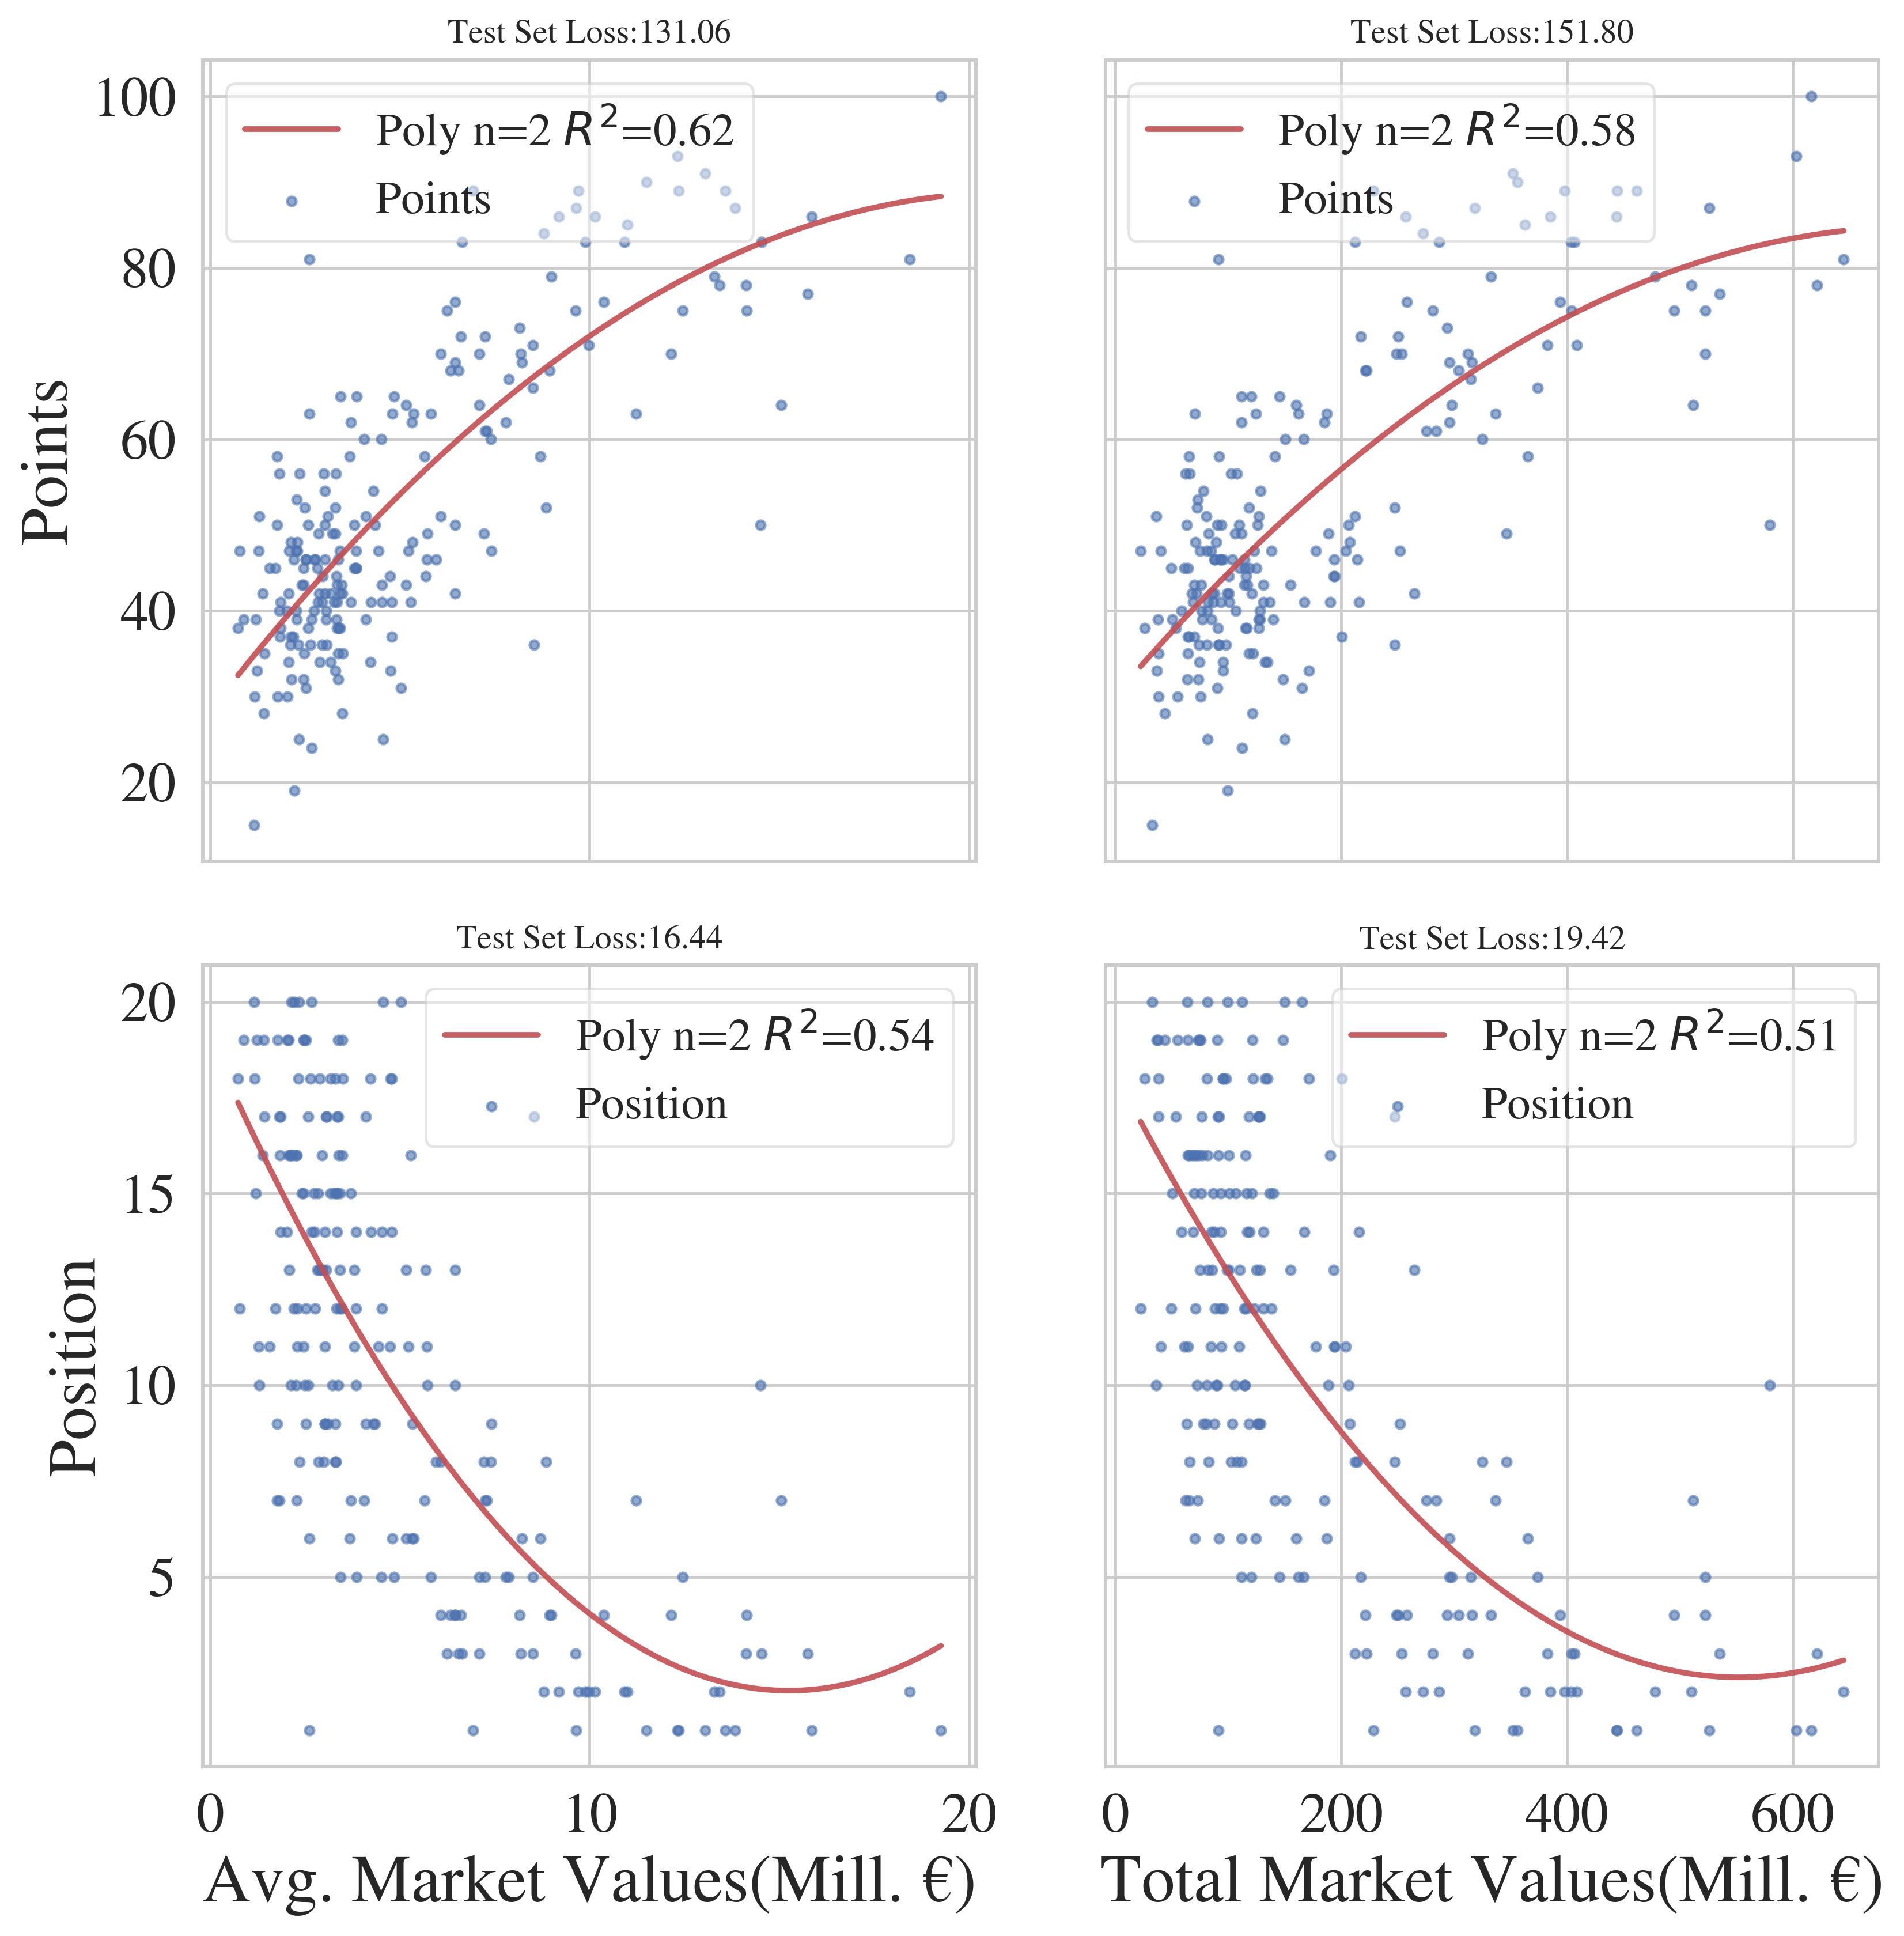

In [23]:
my_poly_2_agent = poly_2_agent()
my_poly_2_agent = poly_2_agent()
my_poly_2_agent.train(train_data=training_set_df)
my_poly_2_agent.evaluate(train_data=training_set_df, test_data=testing_set_df, col_names=numeric_big_summary_df.columns)

From the test set loss evaluation we can tell that a non-linear formula can describe the dataset better, specially on position prediction. The **$R^2$** has a **8.9%** increase on the average market values and position combination. Also the test set loss drops **2.1%** on average market values with position prediction.

Combined with the linear prediction, we can have a conclusion that compared with total market values, average market values has a better correlation with both points and position.

In [39]:
poly_prediction_df = my_poly_2_agent.predict(prediction_input_df)
poly_prediction_df.head(4)

Polynomial Degree 2                               \
                  Avg. Market Values: Points Avg. Market Values: Position   
Manchester City                    43.850872                    44.302148   
Liverpool FC                       73.333759                    22.015094   
Chelsea FC                         82.002938                    14.275902   
Manchester United                  70.112220                    24.653339   

                                                                             
                  Total Market Values: Points Total Market Values: Position  
Manchester City                     71.930953                     15.691206  
Liverpool FC                        81.444203                      8.304676  
Chelsea FC                          82.035467                      7.749881  
Manchester United                   82.677680                      7.112306

### Different Polynomial Degree

In [34]:
from ml_agent import non_linear_agent

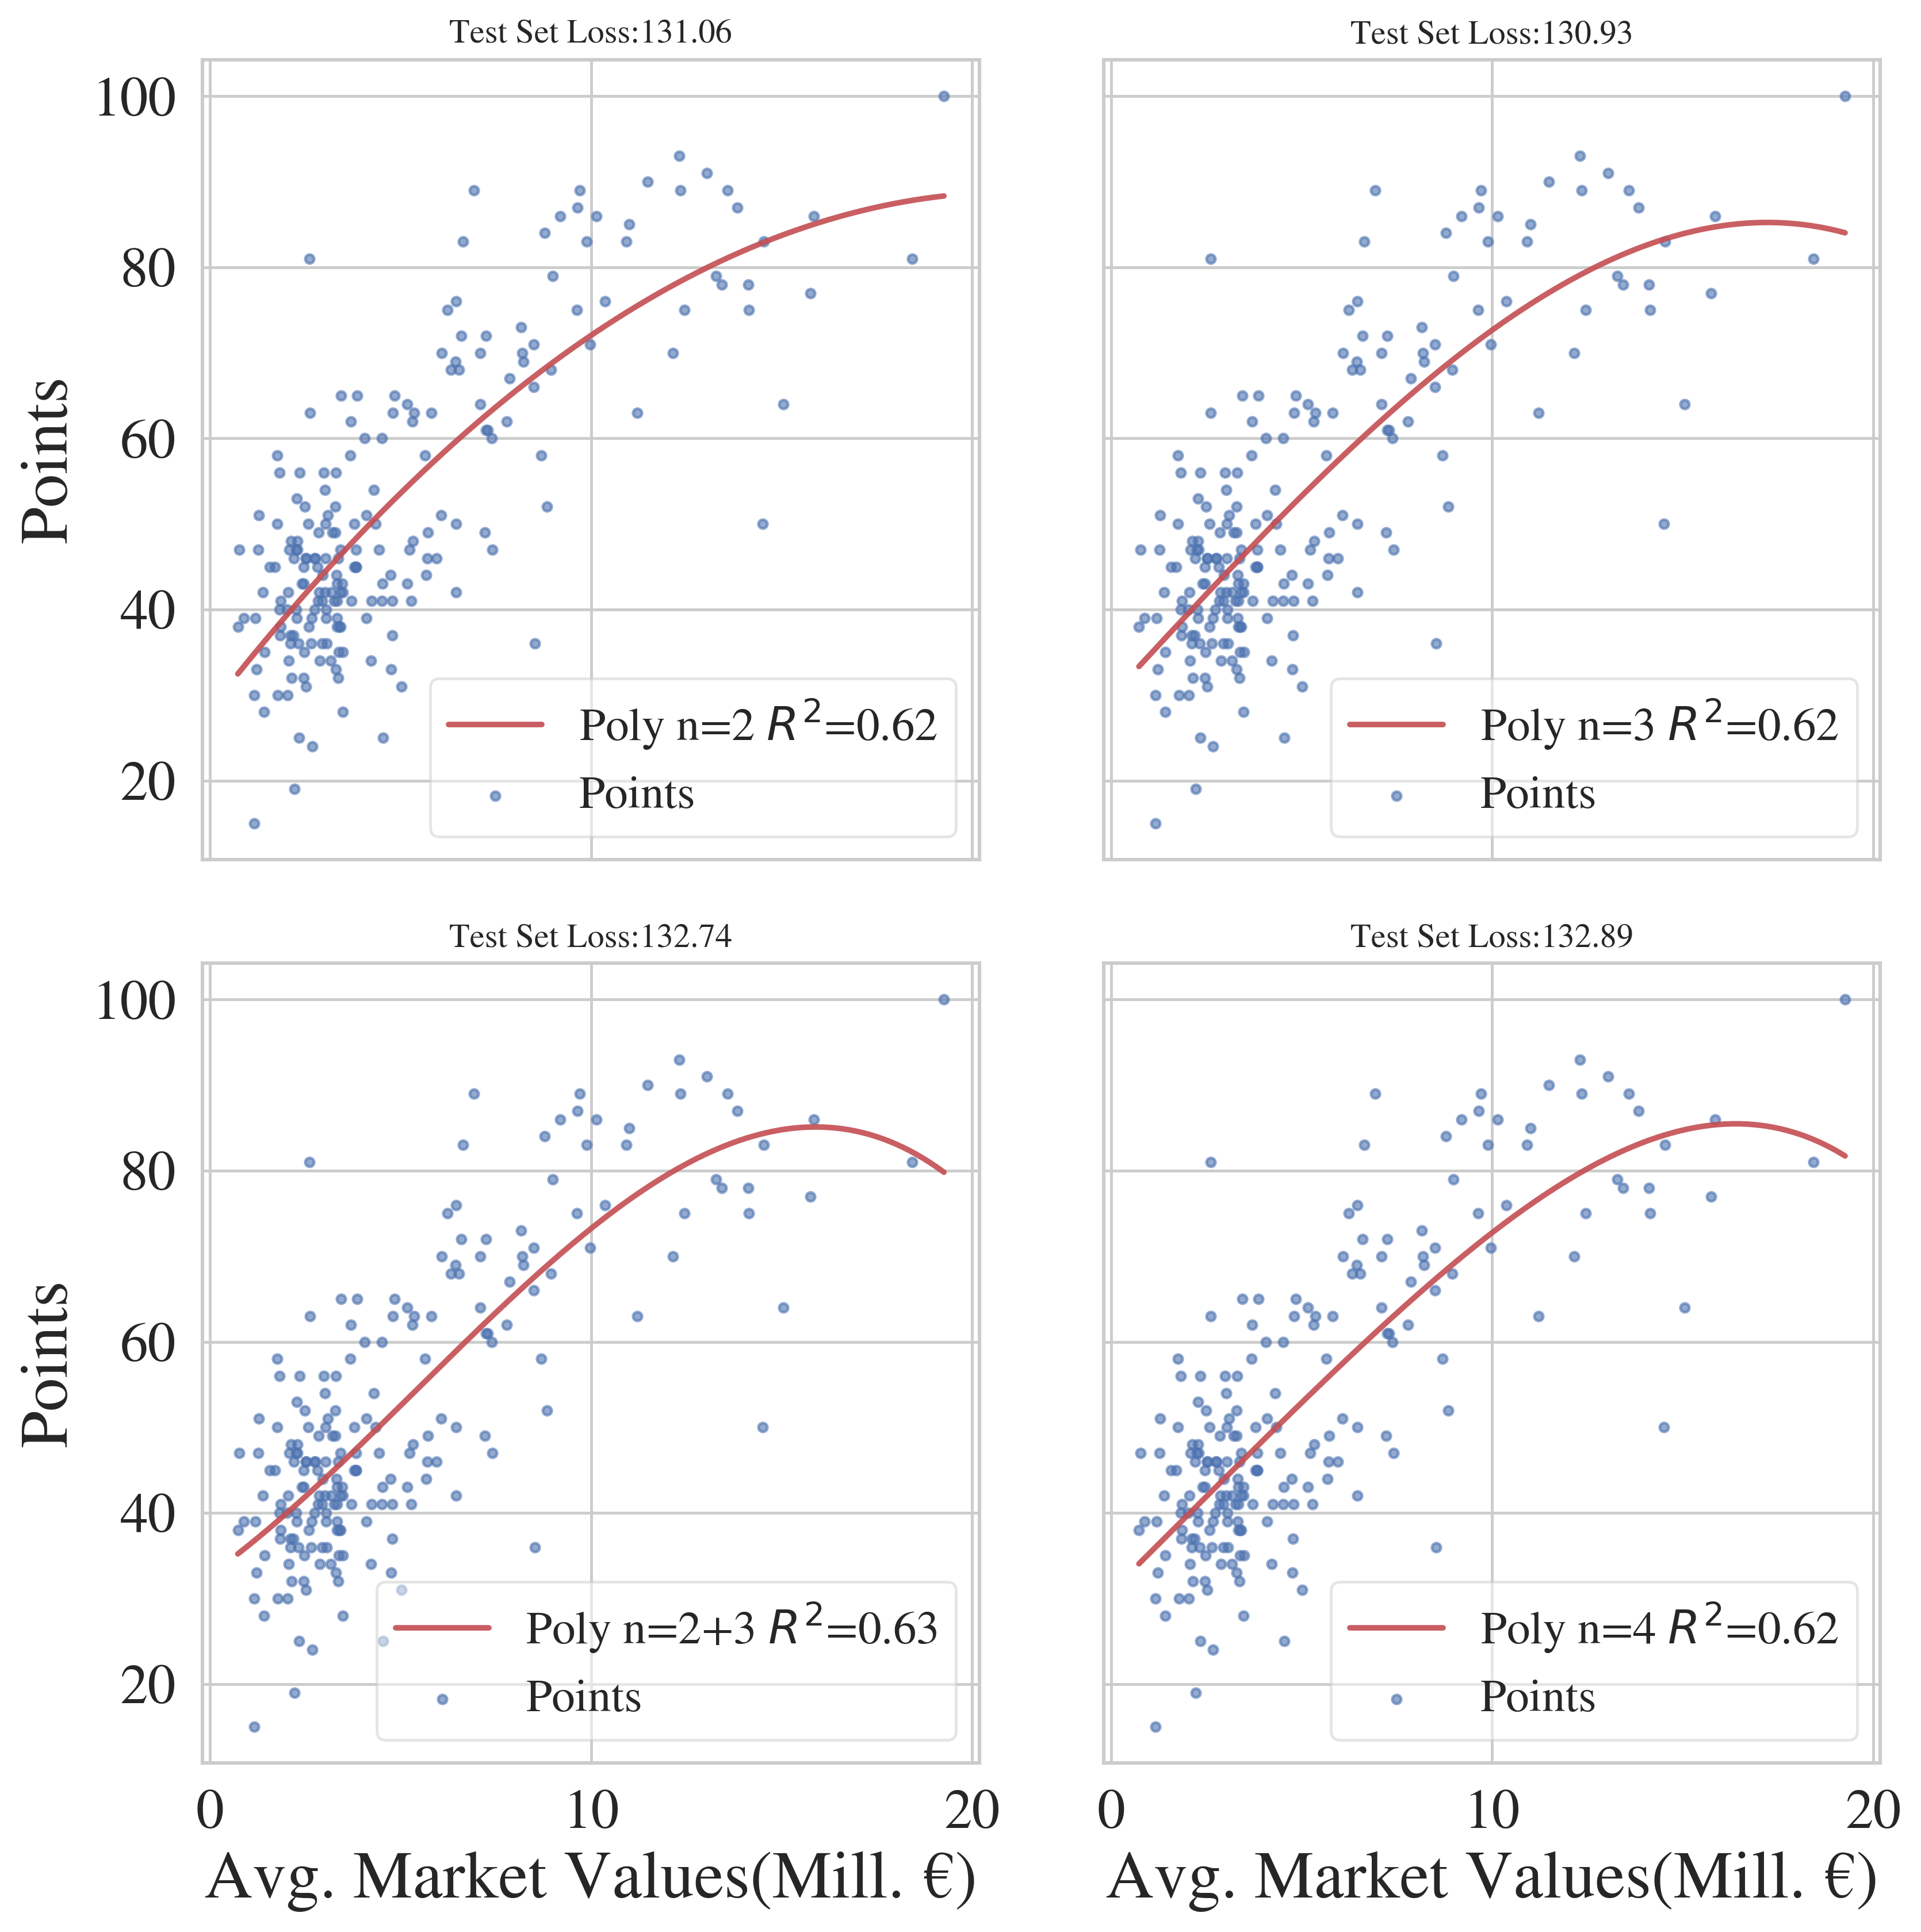

In [35]:
my_non_linear_agent = non_linear_agent()
my_non_linear_agent.train(train_data=training_set_df)
my_non_linear_agent.evaluate(train_data=training_set_df, test_data=testing_set_df,
                             col_names=numeric_big_summary_df.columns)

The Different polynomial degree dosen't affect the performance much. However, judging from the plots, high degree polynomial hypothesis function seems suffer from the over-fitting problem.

In [38]:
non_linear_prediction = my_non_linear_agent.predict(prediction_input_df)
non_linear_prediction.head(4)

Non-linear Model                        \
                  Polynomial Degree 2 Polynomial Degree 2+3   
Manchester City             43.850872           -320.701708   
Liverpool FC                73.333759            -76.241116   
Chelsea FC                  82.002938             -4.172501   
Manchester United           70.112220           -102.554265   

                                                           
                  Polynomial Degree 3 Polynomial Degree 4  
Manchester City           -110.677992         -399.535845  
Liverpool FC                 8.687348          -86.504904  
Chelsea FC                  44.156500           -3.800464  
Manchester United           -4.245623         -118.043264

The prediction is not convincing enough for the real situation even for the polynomial with degree of 2. A negative points demonstrates the model suffers the over-fitting problem just like we inferred on plots observation. 

## K Nearest Neighbour
---
